In [9]:
from __future__ import annotations

import pandas as pd           # o polars as pl, si prefieres
from datetime import datetime, timedelta
from pathlib import Path      # ← solo Path; PureWindowsPath ya no hace falta

# Rutas base — ajusta solo estas dos líneas si cambian
RUTA_DIARIA = Path(r"\\nas-cen1\Estadisticas\progdiar_SEN\25")
RUTA_INTRAD = Path(r"\\nas-cen1\Estadisticas\progintradiaria_SEN\25")


In [94]:
from __future__ import annotations

import pandas as pd, requests, urllib3
from datetime import datetime, timedelta
from pathlib import Path

urllib3.disable_warnings()

# ───────────────────── CONFIG ─────────────────────
RUTA_DIARIA  = Path(r"\\nas-cen1\Estadisticas\progdiar_SEN\25")
RUTA_INTRAD  = Path(r"\\nas-cen1\Estadisticas\progintradiaria_SEN\25")

CENTRALES    = ["PE-HORIZONTESUR", "PE-HORIZONTENORTE"]
USER_KEY     = "02f127c082259fcb5d4f2c95a454be58"
TIMEOUT_SEC  = 30

MAP_ERV2NEMO = {
    "PE-HORIZONTENORTE": "epehorizonte",
    "PE-HORIZONTESUR":   "epehorizonte-sur",
}
NEMOS    = set(MAP_ERV2NEMO.values())
NEMO2ERV = {v: k for k, v in MAP_ERV2NEMO.items()}

# ───────────────────── Fechas ─────────────────────
def fechas_yymmdd(start: str, end: str) -> list[str]:
    d0, d1 = map(lambda s: datetime.strptime(s, "%Y-%m-%d").date(), (start, end))
    return [(d0 + timedelta(days=i)).strftime("%y%m%d") for i in range((d1 - d0).days + 1)]

def fechas_iso(start: str, end: str) -> list[str]:
    d0, d1 = map(lambda s: datetime.strptime(s, "%Y-%m-%d").date(), (start, end))
    return [(d0 + timedelta(days=i)).isoformat() for i in range((d1 - d0).days + 1)]

# ───────────────────── Excel helpers ─────────────────────
def ruta_excel(yymmdd: str) -> Path | None:
    for name in (f"PRG{yymmdd}_consolidado.xlsx", f"PRG{yymmdd}.xlsx"):
        p = RUTA_INTRAD / name if "_consolidado" in name else RUTA_DIARIA / name
        if p.exists():
            return p
    return None

def leer_erv(ruta: Path, yymmdd: str) -> pd.DataFrame | None:
    df = pd.read_excel(ruta, sheet_name="ERV", engine="openpyxl")
    df["fecha"] = pd.to_datetime(yymmdd, format="%y%m%d")
    patron = "|".join(CENTRALES)
    col    = df.columns[1]                       # segunda columna = nombre
    df     = df[df[col].fillna("").str.contains(patron, case=False, regex=True)]
    return df if not df.empty else None

def leer_programa(ruta: Path, yymmdd: str) -> pd.DataFrame | None:
    """
    Lee la hoja PROGRAMA y devuelve solo PE-HORIZONTESUR y PE-HORIZONTENORTE.

    •   En los archivos reales, las dos primeras columnas (0-1) son vacías,
        la **columna 2** contiene el nombre de la central,
        la **columna 3** está vacía y se descarta.
    •   Las horas 1-24 están en las columnas 4 … 27.
    •   Identificamos la fila donde aparecen 1-24 para usarla como cabecera.
    """
    raw = pd.read_excel(ruta, sheet_name="PROGRAMA", header=None, engine="openpyxl")

    # 1) localizar fila con cabezera 1-24 en las columnas 4-27
    def es_cabecera(fila: pd.Series) -> bool:
        valores = fila.iloc[4:28].tolist()
        return valores == list(range(1, 25))

    hdr_idx = raw[raw.apply(es_cabecera, axis=1)].index
    if hdr_idx.empty:
        print(f"[WARN] {ruta.name}: cabecera 1-24 no detectada")
        return None
    hdr = hdr_idx[0]

    # 2) construir DataFrame: filas desde hdr+1, redefine columnas
    df = raw.iloc[hdr + 1:].reset_index(drop=True)
    df.columns = ["_c0", "_c1", "central_erv", "_drop", *range(1, 25), "Total"]

    df = df.drop(columns=["_c0", "_c1", "_drop", "Total"])  # elimina basura/total

    # 3) filtrar solo las centrales deseadas
    patron = "|".join(CENTRALES)
    df = df[df["central_erv"].fillna("").str.contains(patron, case=False, regex=True)]
    if df.empty:
        return None

    df["fecha"] = pd.to_datetime(yymmdd, format="%y%m%d")
    return df


# ───────────────────── API generación real ─────────────────────
def extrae_real(llaves: pd.DataFrame, fecha_iso: str) -> pd.DataFrame | None:
    url = f"https://operacion.api.coordinador.cl/opreal-medidas/v1/bydate?created={fecha_iso}&type=1&user_key={USER_KEY}"
    try:
        data = requests.get(url, verify=False, timeout=TIMEOUT_SEC).json()
    except Exception as exc:
        print(f"[API] {fecha_iso}: {exc}")
        return None

    df = (pd.json_normalize(data)
            .drop_duplicates("idMeasure", keep="last")
            .rename(columns={
                "topologyNaturalKey": "natural_key",
                "topologyTimeHour":   "hour",
                "topologyTimeDateMeasure": "date",
                "measure": "value"}))

    if df.empty:
        return None

    df["date"] = (
        pd.to_datetime(df["date"].str.replace("Z", "", regex=False))
        .dt.strftime("%Y-%m-%d")
    )

    df = (df.sort_values("hour")
            .drop_duplicates(["natural_key", "hour", "date"], keep="last"))

    df = df[df["natural_key"].isin(NEMOS)]
    if df.empty:
        return None

    df["central_erv"] = df["natural_key"].map(NEMO2ERV)
    llaves = llaves[["llave_nemotecnico"]].rename(columns={"llave_nemotecnico": "natural_key"})
    return df.merge(llaves, on="natural_key", how="inner")

# ───────────────────── Orquestador ─────────────────────
def cargar_todo(desde: str, hasta: str, llaves_df: pd.DataFrame
               ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    erv, prog, real = [], [], []

    for yy, iso in zip(fechas_yymmdd(desde, hasta), fechas_iso(desde, hasta)):
        ruta = ruta_excel(yy)
        if ruta:
            dfe = leer_erv(ruta, yy)
            if dfe is not None:
                erv.append(dfe)
                print(f"[ERV]  {ruta.name}  {len(dfe)} filas")

            dfp = leer_programa(ruta, yy)
            if dfp is not None:
                prog.append(dfp)
                print(f"[PROG] {ruta.name}  {len(dfp)} filas")
        else:
            print(f"[ARCH] {yy}: Excel no encontrado")

        dfr = extrae_real(llaves_df, iso)
        if dfr is not None:
            real.append(dfr)
            print(f"[REAL] {iso}  {len(dfr)} filas")

    if not erv:
        raise FileNotFoundError("Sin filas ERV")
    if not prog:
        raise FileNotFoundError("Sin filas PROGRAMA")
    if not real:
        raise RuntimeError("La API de generación real no devolvió datos")

    return (pd.concat(erv,  ignore_index=True),
            pd.concat(real, ignore_index=True),
            pd.concat(prog, ignore_index=True))


In [137]:
llaves = pd.DataFrame({"llave_nemotecnico": ["epehorizonte", "epehorizonte-sur"]})
df_erv, df_real, df_prog = cargar_todo("2025-06-20", "2025-07-03", llaves)



[ERV]  PRG250620_consolidado.xlsx  2 filas
[PROG] PRG250620_consolidado.xlsx  2 filas
[REAL] 2025-06-20  48 filas
[ERV]  PRG250621_consolidado.xlsx  2 filas
[PROG] PRG250621_consolidado.xlsx  2 filas
[REAL] 2025-06-21  48 filas
[ERV]  PRG250622_consolidado.xlsx  2 filas
[PROG] PRG250622_consolidado.xlsx  2 filas
[REAL] 2025-06-22  48 filas
[ERV]  PRG250623.xlsx  2 filas
[PROG] PRG250623.xlsx  2 filas
[REAL] 2025-06-23  48 filas
[ERV]  PRG250624_consolidado.xlsx  2 filas
[PROG] PRG250624_consolidado.xlsx  2 filas
[REAL] 2025-06-24  48 filas
[ERV]  PRG250625_consolidado.xlsx  2 filas
[PROG] PRG250625_consolidado.xlsx  2 filas
[REAL] 2025-06-25  48 filas
[ERV]  PRG250626_consolidado.xlsx  2 filas
[PROG] PRG250626_consolidado.xlsx  2 filas
[REAL] 2025-06-26  48 filas
[ERV]  PRG250627.xlsx  2 filas
[PROG] PRG250627.xlsx  2 filas
[REAL] 2025-06-27  48 filas
[ERV]  PRG250628_consolidado.xlsx  2 filas
[PROG] PRG250628_consolidado.xlsx  2 filas
[REAL] 2025-06-28  48 filas
[ERV]  PRG250629_conso

In [138]:
import pandas as pd

# Asumiendo que ya cargaste el archivo original como df_erv:
# Elimina la primera columna innecesaria
df_erv = df_erv.iloc[:, 1:]

# Renombra columnas
n_cols = df_erv.shape[1]
df_erv.columns = ['central_erv'] + list(range(1, n_cols - 1)) + ['fecha']

# Verifica resultado
print(df_erv.head())


         central_erv       1       2       3       4       5       6       7  \
0    PE-HORIZONTESUR  174.89  129.78  127.25  125.40  130.30  127.80  128.00   
1  PE-HORIZONTENORTE   73.48   57.72   55.24   59.10   62.40   65.30   73.80   
2    PE-HORIZONTESUR   325.1  327.36  327.08  329.73  327.81  329.47  331.21   
3  PE-HORIZONTENORTE    85.1  100.63  105.56  108.38  115.87  109.18  109.65   
4    PE-HORIZONTESUR    37.7   81.90  110.70  122.90  133.50  147.80  157.30   

        8       9  ...     17     18     19     20     21     22    23     24  \
0  155.40  147.90  ...   85.2   88.3   86.6  103.1  121.4  124.4  75.7   32.1   
1   97.40  101.00  ...  165.4  167.0  173.3  137.0   98.7   72.3  52.2   36.8   
2  320.06  275.45  ...  118.8   79.2   58.5   52.9   43.1   36.4  39.0   40.2   
3  102.62   91.10  ...   92.5   55.2   36.1   35.5   33.7   49.8  54.7   70.6   
4  155.80  137.80  ...   46.3   32.8   29.8   25.7   18.0   31.0  72.4  120.4   

        25      fecha  
0  2794.

In [139]:
import pandas as pd

# ──────────────────────────────────────────────────────────────
# 1. df_erv → formato largo (solo horas 1-24)
# ──────────────────────────────────────────────────────────────
hour_cols = list(range(1, 25))  # columnas 1 a 24

df_erv_long = (
    df_erv.melt(id_vars=["central_erv", "fecha"],
                value_vars=hour_cols,
                var_name="hour", value_name="value_erv")
)
df_erv_long["hour"] = df_erv_long["hour"].astype(int)
df_erv_long["fecha"] = pd.to_datetime(df_erv_long["fecha"])
df_erv_long["central_erv"] = df_erv_long["central_erv"].astype(str)

# ──────────────────────────────────────────────────────────────
# 2. df_prog → formato largo (solo horas 1-24)
# ──────────────────────────────────────────────────────────────
prog_hour_cols = [c for c in df_prog.columns if isinstance(c, int) and c in range(1, 25)]

df_prog_long = (
    df_prog.melt(id_vars=["central_erv", "fecha"],
                 value_vars=prog_hour_cols,
                 var_name="hour", value_name="value_prog")
)
df_prog_long["hour"] = df_prog_long["hour"].astype(int)
df_prog_long["fecha"] = pd.to_datetime(df_prog_long["fecha"])
df_prog_long["central_erv"] = df_prog_long["central_erv"].astype(str)

# ──────────────────────────────────────────────────────────────
# 3. df_real → renombrar columnas y asegurar tipos
# ──────────────────────────────────────────────────────────────
df_real_tidy = (
    df_real.rename(columns={"value": "value_real", "date": "fecha"})
            .astype({"hour": int})
)
df_real_tidy["fecha"] = pd.to_datetime(df_real_tidy["fecha"])
df_real_tidy["central_erv"] = df_real_tidy["central_erv"].astype(str)

# ──────────────────────────────────────────────────────────────
# 4. MERGE triple (real ∩ ERV ∩ PROG)
# ──────────────────────────────────────────────────────────────
df_tot = (
    df_real_tidy
      .merge(df_erv_long,  on=["central_erv", "fecha", "hour"], how="inner")
      .merge(df_prog_long, on=["central_erv", "fecha", "hour"], how="left")  # left por si hay vacíos
      .sort_values(["central_erv", "fecha", "hour"])
      .reset_index(drop=True)
)

# ──────────────────────────────────────────────────────────────
# 5. Timestamp continuo (fecha + hora)
# ──────────────────────────────────────────────────────────────
df_tot["timestamp"] = df_tot["fecha"] + pd.to_timedelta(df_tot["hour"] - 1, unit="h")

# ──────────────────────────────────────────────────────────────
# Resultado final
# ──────────────────────────────────────────────────────────────
print(df_tot.head())


    idMeasure  value_real  topologyId        topologyName   natural_key  \
0  1781477186        40.0       16818  PE Horizonte Norte  epehorizonte   
1  1782925652        40.0       16818  PE Horizonte Norte  epehorizonte   
2  1787277524        39.9       16818  PE Horizonte Norte  epehorizonte   
3  1787277523        40.0       16818  PE Horizonte Norte  epehorizonte   
4  1787277525         0.0       16818  PE Horizonte Norte  epehorizonte   

       fecha  hour topologyTimeLevel        central_erv value_erv value_prog  \
0 2025-06-20     1              hour  PE-HORIZONTENORTE     73.48       73.5   
1 2025-06-20     2              hour  PE-HORIZONTENORTE     57.72       57.7   
2 2025-06-20     3              hour  PE-HORIZONTENORTE     55.24       55.2   
3 2025-06-20     4              hour  PE-HORIZONTENORTE      59.1       59.1   
4 2025-06-20     5              hour  PE-HORIZONTENORTE      62.4       62.4   

            timestamp  
0 2025-06-20 00:00:00  
1 2025-06-20 01:00:0

PE-HORIZONTENORTE: ERROR PROMEDIO DIARIO = 92.24 MW


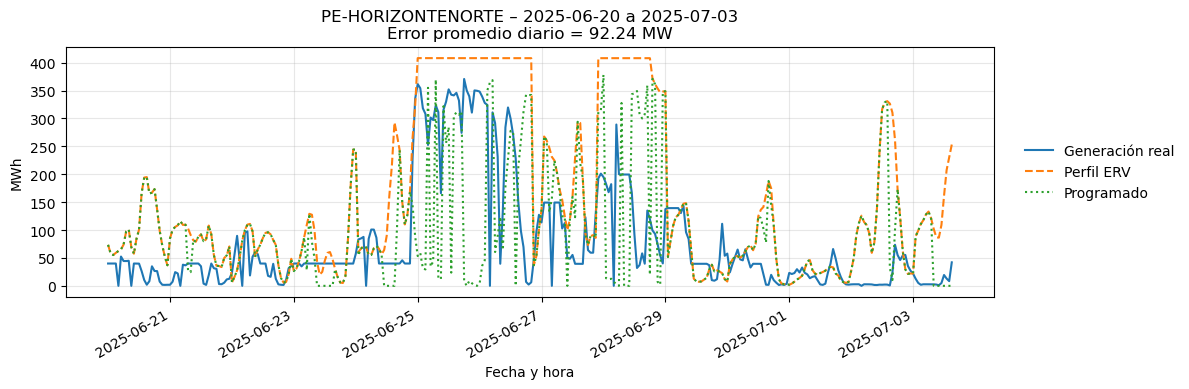

PE-HORIZONTESUR: ERROR PROMEDIO DIARIO = 143.47 MW


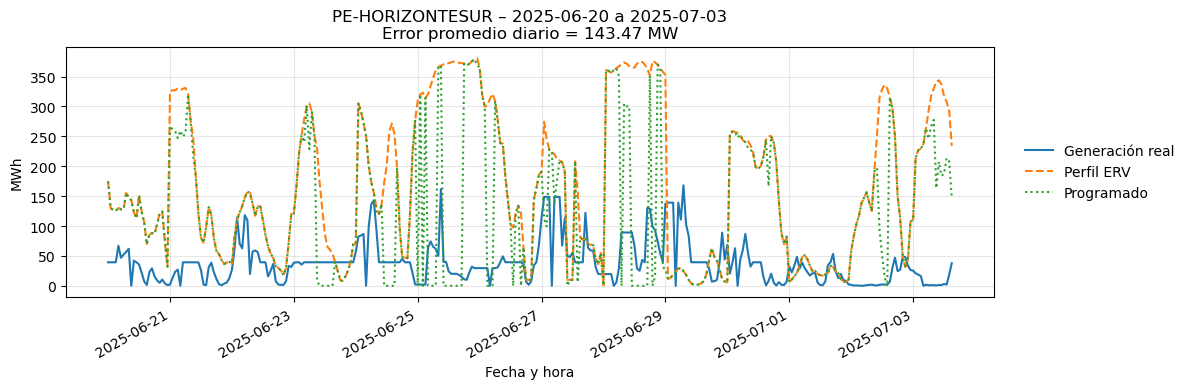

In [140]:
import numpy as np
import matplotlib.pyplot as plt

CENTRALES = df_tot["central_erv"].unique()
DESDE, HASTA = "2025-06-20", "2025-07-03"

for central in CENTRALES:
    sub = df_tot[df_tot["central_erv"] == central].sort_values("timestamp")

    # ─── Métricas ──────────────────────────────────────────────
    diff  = sub["value_real"] - sub["value_erv"]
    rmse  = np.sqrt(np.mean(diff ** 2))
    mad   = np.mean(np.abs(diff))
    mask  = sub["value_real"] != 0
    mape  = (np.abs(diff[mask] / sub.loc[mask, "value_real"]).mean()) * 100

    print(f"{central}: ERROR PROMEDIO DIARIO = {mad:,.2f} MW")

    # ─── Gráfico ───────────────────────────────────────────────
    plt.figure(figsize=(12, 4))

    plt.plot(sub["timestamp"], sub["value_real"],
             label="Generación real", linewidth=1.5)
    plt.plot(sub["timestamp"], sub["value_erv"],
             label="Perfil ERV", linestyle="--", linewidth=1.5)
    plt.plot(sub["timestamp"], sub["value_prog"],
             label="Programado", linestyle=":", linewidth=1.5)

    plt.title(
        f"{central} – {DESDE} a {HASTA}\n"
        f"Error promedio diario = {mad:,.2f} MW"
    )
    plt.xlabel("Fecha y hora")
    plt.ylabel("MWh")
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45, ha="right")
    plt.gcf().autofmt_xdate()

    # Leyenda a la derecha
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    plt.tight_layout()
    plt.show()


PE-HORIZONTENORTE:
   - Error promedio horario ERV   = 92.24 MW
   - Error promedio horario PROG  = 84.83 MW


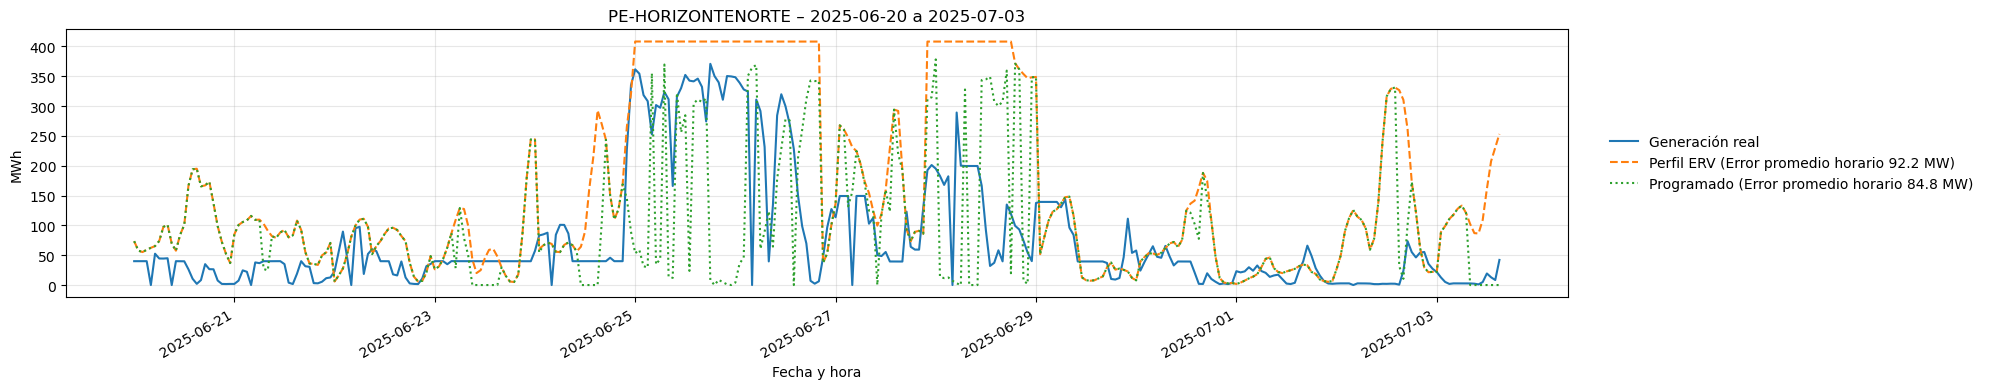

PE-HORIZONTESUR:
   - Error promedio horario ERV   = 143.47 MW
   - Error promedio horario PROG  = 106.31 MW


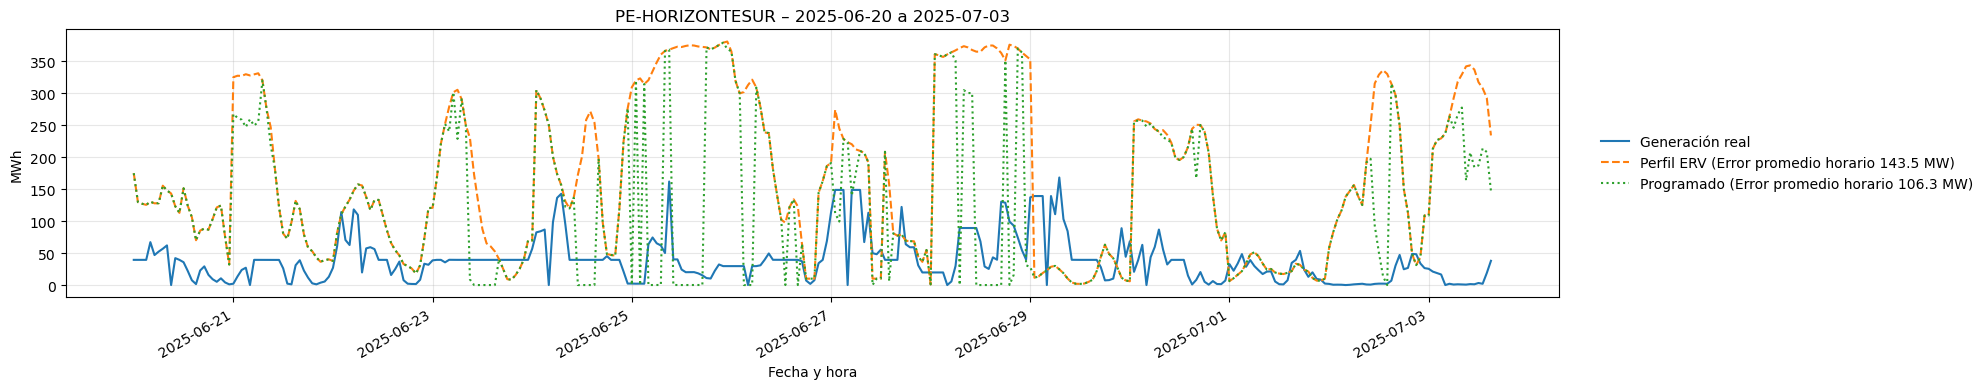

In [149]:
import numpy as np
import matplotlib.pyplot as plt

CENTRALES = df_tot["central_erv"].unique()
DESDE, HASTA = "2025-06-20", "2025-07-03"

for central in CENTRALES:
    sub = df_tot[df_tot["central_erv"] == central].sort_values("timestamp")

    # ─── Errores por punto horario ─────────────────────────────
    err_erv  = sub["value_real"] - sub["value_erv"]
    err_prog = sub["value_real"] - sub["value_prog"]

    # ─── Métricas de error promedio horario ────────────────────
    mad_erv  = np.mean(np.abs(err_erv))
    mad_prog = np.mean(np.abs(err_prog))

    print(f"{central}:")
    print(f"   - Error promedio horario ERV   = {mad_erv:,.2f} MW")
    print(f"   - Error promedio horario PROG  = {mad_prog:,.2f} MW")

    # ─── Gráfico ───────────────────────────────────────────────
    plt.figure(figsize=(20, 4))

    plt.plot(sub["timestamp"], sub["value_real"],
             label="Generación real", linewidth=1.5)
    plt.plot(sub["timestamp"], sub["value_erv"],
             label=f"Perfil ERV (Error promedio horario {mad_erv:,.1f} MW)", linestyle="--", linewidth=1.5)
    plt.plot(sub["timestamp"], sub["value_prog"],
             label=f"Programado (Error promedio horario {mad_prog:,.1f} MW)", linestyle=":", linewidth=1.5)

    plt.title(
        f"{central} – {DESDE} a {HASTA}"
    )
    plt.xlabel("Fecha y hora")
    plt.ylabel("MWh")
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45, ha="right")
    plt.gcf().autofmt_xdate()

    # Leyenda a la derecha
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    plt.tight_layout()
    plt.show()



PE-HORIZONTENORTE – error diario:


C:\Users\maria.perez\AppData\Local\Temp\ipykernel_23572\1500693879.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(metrics_daily)


,date,RMSE,MAPE
0,2025-06-20,91.22,1077.28
1,2025-06-21,63.46,790.49
2,2025-06-22,42.47,211.37
3,2025-06-23,62.99,105.88
4,2025-06-24,109.96,177.67
5,2025-06-25,97.05,30.62
6,2025-06-26,218.47,1347.91
7,2025-06-27,121.68,142.99
8,2025-06-28,268.49,334.39
9,2025-06-29,57.06,71.55


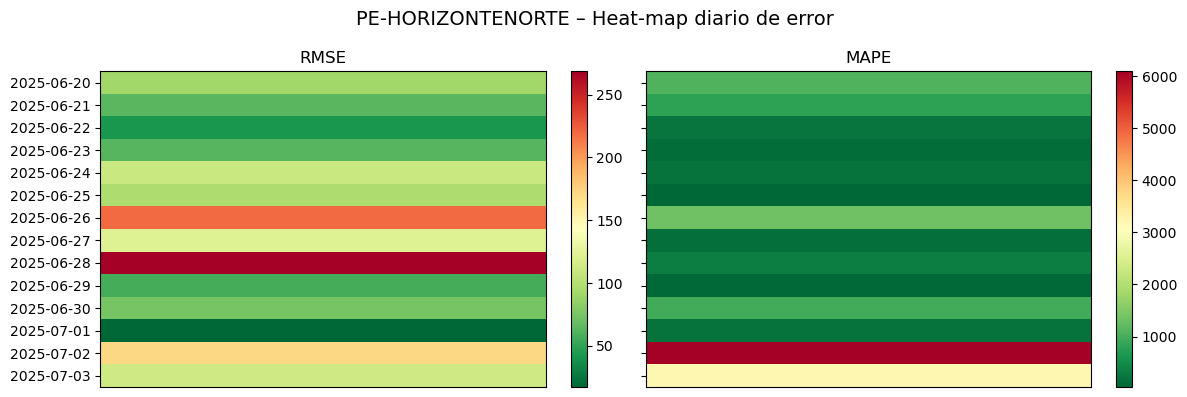

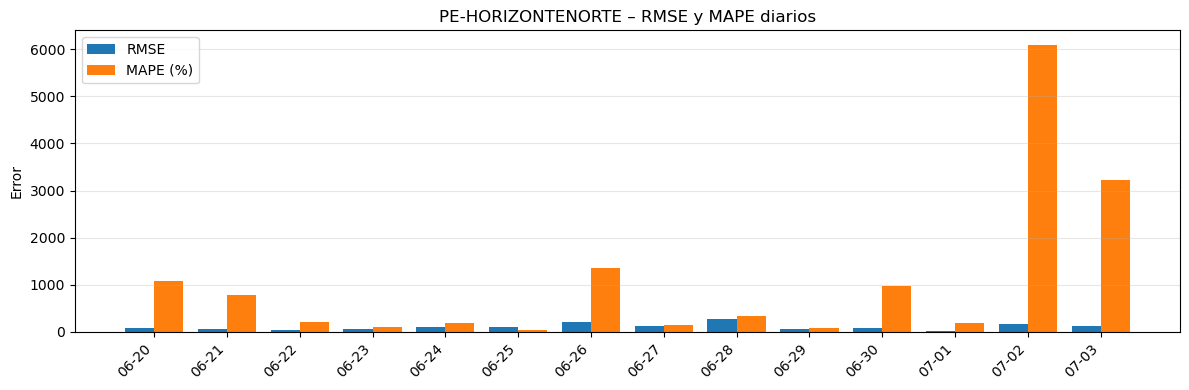


PE-HORIZONTESUR – error diario:


,date,RMSE,MAPE
14,2025-06-20,88.59,786.68
15,2025-06-21,193.07,1905.08
16,2025-06-22,56.71,298.00
17,2025-06-23,140.88,267.31
18,2025-06-24,148.25,736.71
19,2025-06-25,326.37,3535.68
20,2025-06-26,185.48,479.79
21,2025-06-27,75.25,95.18
22,2025-06-28,301.94,974.89
23,2025-06-29,86.65,140.51


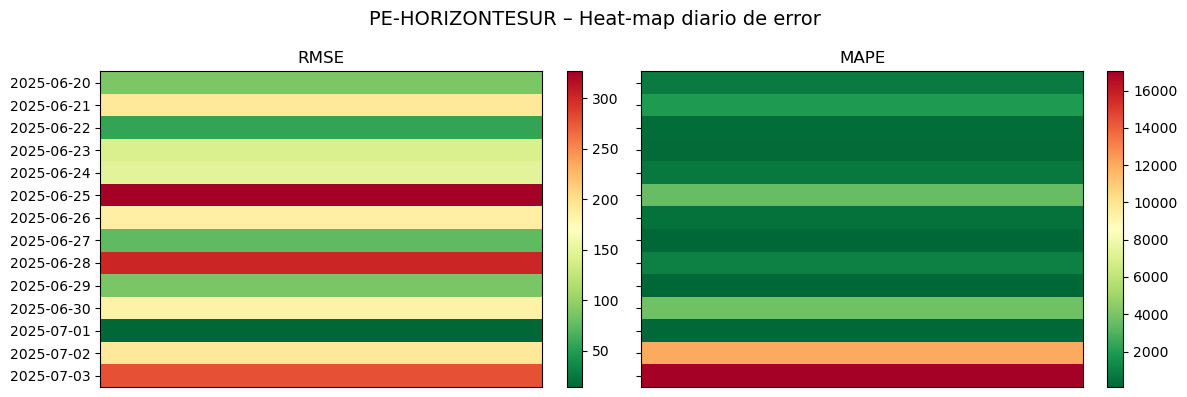

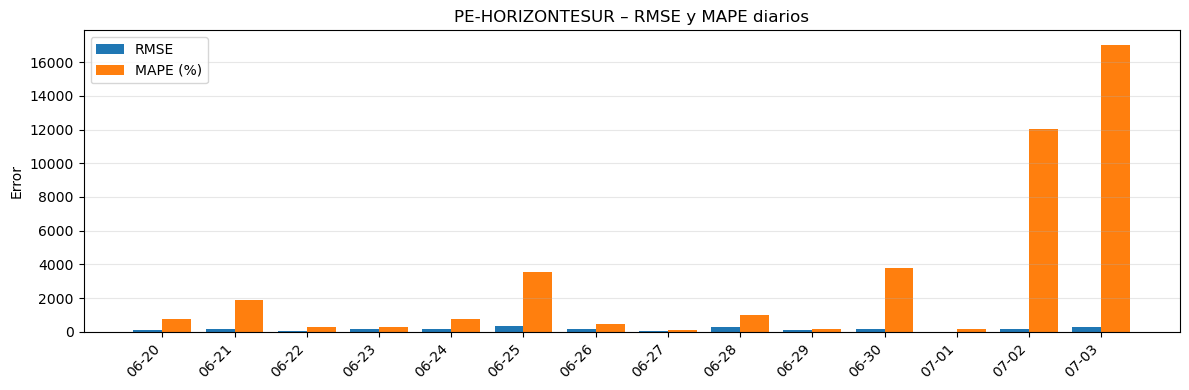

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

# ──────────────────────────────────────────────────────────────
# 1. Calcular RMSE y MAPE por fecha y central
# ──────────────────────────────────────────────────────────────
def metrics_daily(group: pd.DataFrame) -> pd.Series:
    diff = group["value_real"] - group["value_erv"]
    rmse = np.sqrt(np.mean(diff**2))
    # MAPE: ignora reales = 0
    mask = group["value_real"] != 0
    mape = (np.abs(diff[mask] / group.loc[mask, "value_real"]).mean()) * 100
    return pd.Series({"RMSE": rmse, "MAPE": mape})

daily = (
    df_tot
      .groupby(["central_erv", df_tot["fecha"].dt.date])
      .apply(metrics_daily)
      .reset_index()
      .rename(columns={"fecha": "date"})
)

# ──────────────────────────────────────────────────────────────
# 2. Mostrar por central
# ──────────────────────────────────────────────────────────────
CENTRALES = daily["central_erv"].unique()

for central in CENTRALES:
    d = daily[daily["central_erv"] == central].copy()
    d["date"] = pd.to_datetime(d["date"])

    # 2-a  Tabla resumen
    print(f"\n{central} – error diario:")
    display(d[["date", "RMSE", "MAPE"]].round(2))

    # 2-b  Heat-map (RMSE)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    for i, metric in enumerate(["RMSE", "MAPE"]):
        pivot = d.pivot(index="date", columns="central_erv", values=metric)
        im = ax[i].imshow(pivot, aspect="auto", cmap="RdYlGn_r")
        ax[i].set_title(metric)
        ax[i].set_xticks([])                     # solo eje Y con fechas
        ax[i].set_yticks(range(len(pivot.index)))
        ax[i].set_yticklabels([dt.strftime("%Y-%m-%d") for dt in pivot.index])
        fig.colorbar(im, ax=ax[i], fraction=0.046)

    fig.suptitle(f"{central} – Heat-map diario de error", fontsize=14)
    plt.tight_layout()
    plt.show()

    # 2-c  Barras dobles
    width = 0.4
    x = np.arange(len(d))
    plt.figure(figsize=(12, 4))
    plt.bar(x - width/2, d["RMSE"], width, label="RMSE")
    plt.bar(x + width/2, d["MAPE"], width, label="MAPE (%)")
    plt.xticks(x, [dt.strftime("%m-%d") for dt in d["date"]], rotation=45, ha="right")
    plt.ylabel("Error")
    plt.title(f"{central} – RMSE y MAPE diarios")
    plt.grid(True, axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [71]:
import math
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# 4. Un subplot por día para cada central
# ----------------------------------------------------------
CENTRALES = df_tot["central_erv"].unique()
DESDE, HASTA = "2025-06-20", "2025-07-03"

for central in CENTRALES:
    sub = df_tot[df_tot["central_erv"] == central]

    # lista de fechas ordenadas
    fechas = sorted(sub["fecha"].dt.date.unique())
    ndays  = len(fechas)

    # define la grilla: p. ej. 3 columnas
    ncols = 3
    nrows = math.ceil(ndays / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 3), sharex=True, sharey=True)
    axes = axes.flatten()          # facilita el acceso lineal

    for i, fecha in enumerate(fechas):
        ax  = axes[i]
        grp = sub[sub["fecha"].dt.date == fecha]

        ax.plot(grp["hour"], grp["value_real"], marker="o", label="Real")
        ax.plot(grp["hour"], grp["value_erv"],  marker="x", linestyle="--", label="Perfil")
        ax.set_title(str(fecha))
        ax.set_xticks(range(1, 25))
        ax.grid(alpha=0.3)

        if i % ncols == 0:
            ax.set_ylabel("MWh")
        if i >= (nrows - 1) * ncols:
            ax.set_xlabel("Hora")

    # borra ejes vacíos si ndays no llena la grilla
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])

    # leyenda única (a la derecha del título)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc="upper right",
               bbox_to_anchor=(0.98, 1.03),   # x ≈ 1, y igual al título
               ncol=1, frameon=False)


    fig.suptitle(f"{central} – {DESDE} a {HASTA}", fontsize=14, y=1.03)
    fig.tight_layout()
    plt.show()
